GPU Server Specs

In [112]:
!nvidia-smi

Sun Nov 26 18:32:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
|  0%   28C    P8    22W / 350W |   6189MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:41:00.0 Off |                  N/A |
|  0%   

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

from transformers import BertTokenizer,BertForSequenceClassification,AdamW

Data Loading and Preprocessing

In [114]:
file_paths = ['data/goemotions_1.csv', 'data/goemotions_2.csv', 'data/goemotions_3.csv']

df_list = [pd.read_csv(file) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)

emotion_labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 
                  'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 
                  'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 
                  'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 
                  'relief', 'remorse', 'sadness', 'surprise', 'neutral']
df = df[['text'] + emotion_labels]

Dataset Size

In [115]:
print(f'Number of Reddit Samples: ',len(df))

Number of Reddit Samples:  211225


In [116]:
df.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Data Processing II

In [117]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

df['text'] = df.text.apply(process_text)

Emotion Distribution Visualization

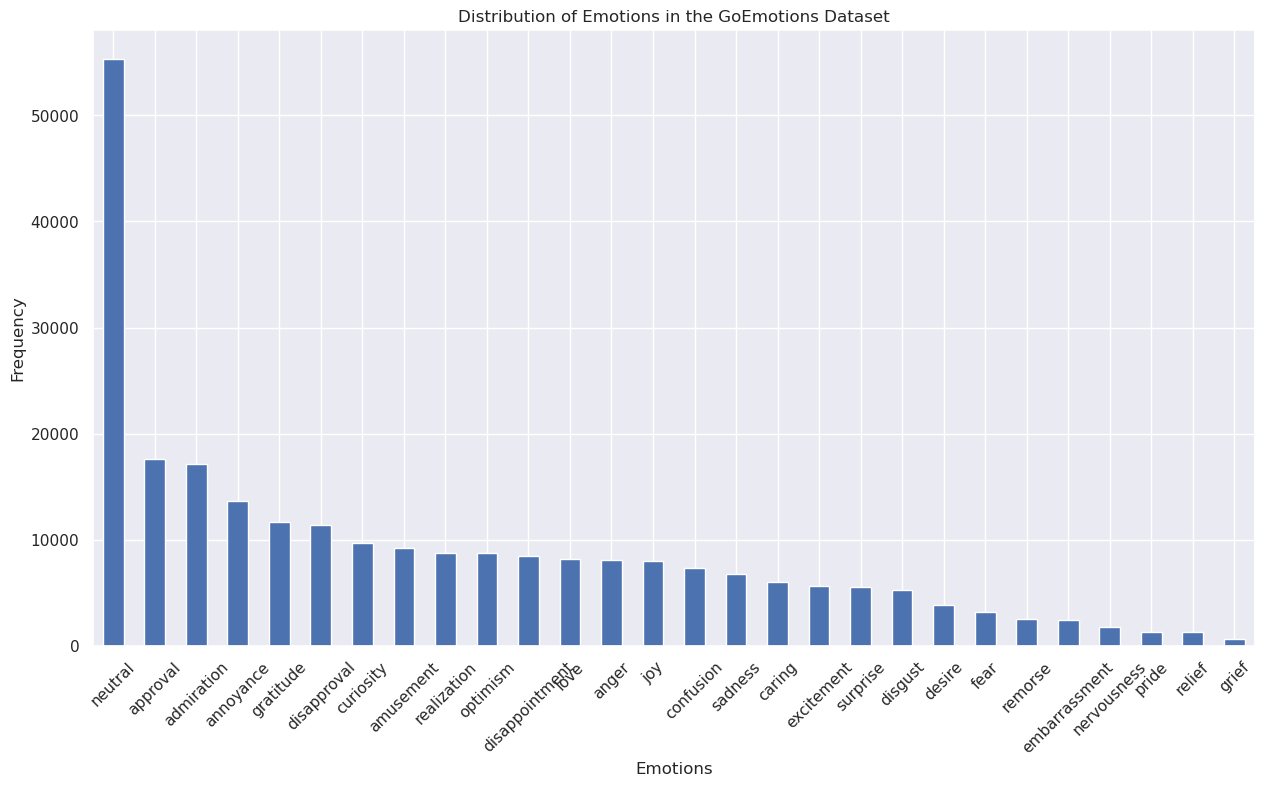

In [118]:
emotion_counts = df[emotion_labels].sum()
sorted_emotion_counts = emotion_counts.sort_values(ascending=False)

plt.figure(figsize=(15, 8))
sorted_emotion_counts.plot(kind='bar')
plt.title('Distribution of Emotions in the GoEmotions Dataset')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Tokenization and Input Formatting

In [119]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
labels = df[emotion_labels].values
texts = df.text.values

input_ids = []
attention_masks = []

for text in texts:
    encoded_data = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_data['input_ids'])
    attention_masks.append(encoded_data['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/home/19aag9/ENTER/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [120]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split
from transformers import get_linear_schedule_with_warmup

Dataset Partitioning

In [121]:
dataset = TensorDataset(input_ids, attention_masks, labels)
total_size = len(dataset)

train_size = int(0.8 * total_size)
test_val_size = total_size - train_size
val_size = int(0.5 * test_val_size)
test_size = test_val_size - val_size

train_dataset, test_val_dataset = random_split(dataset, [train_size, test_val_size])
val_dataset, test_dataset = random_split(test_val_dataset, [val_size, test_size])

batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

print('Training Size:', train_size)
print('Validation Size:', val_size)
print('Test Size:', test_size)

Training Size: 168980
Validation Size: 21122
Test Size: 21123


Pretrained BERT Model

In [122]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(emotion_labels),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Set Random Seed for Reproducibility

In [123]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Training Hyperparameters

In [124]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

/home/19aag9/ENTER/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


device(type='cuda')

Evaluation Function for Validation and Testing Sets

In [125]:
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0

    loss_function = nn.BCEWithLogitsLoss()

    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        labels = batch[2]
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits 

            loss = loss_function(logits, labels.float()) 
            loss_val_total += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = labels.cpu().numpy()
            predictions.append(logits)
            true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

Training Loop: tracking validation and testing sets

In [126]:
from tqdm.notebook import tqdm

loss_function = nn.BCEWithLogitsLoss()

train_losses = []
val_losses = []

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()

        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_function(logits, labels.float())
        loss_train_total += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    tqdm.write(f'\nEpoch {epoch}')
    train_loss = loss_train_total/len(train_dataloader)   
    train_losses.append(train_loss)         
    tqdm.write(f'Training loss: {train_loss}')

    val_loss, predictions, true_labels = evaluate(validation_dataloader)
    val_losses.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/5281 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.13000203135778363
Validation loss: 0.11364170345343909


Epoch 2:   0%|          | 0/5281 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.10954720564461684
Validation loss: 0.11132314556620666


Epoch 3:   0%|          | 0/5281 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.10392213421204487
Validation loss: 0.11118024625954938


Epoch 4:   0%|          | 0/5281 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.09973483431863528
Validation loss: 0.11237489705998309


Visualizing Training and Validation Loss

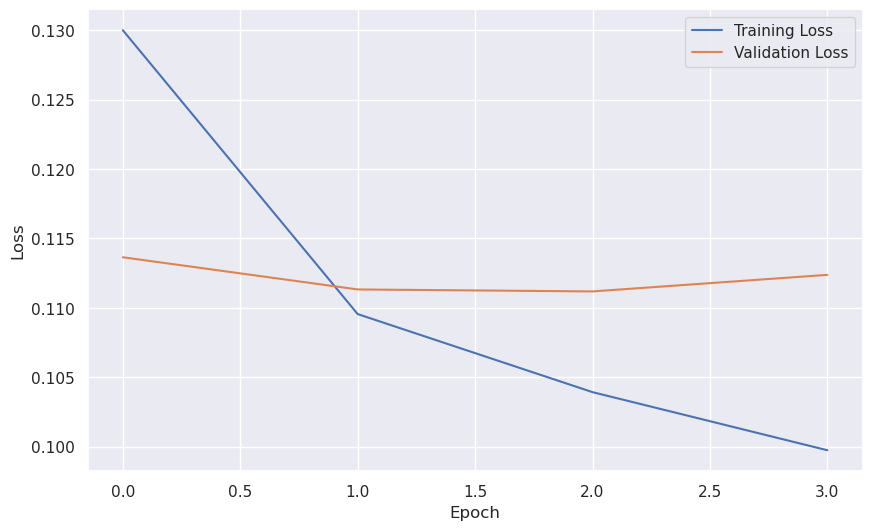

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Save the finetuned BERT model

In [128]:
output_dir = './goemotions'


In [138]:
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./goemotions/tokenizer_config.json',
 './goemotions/special_tokens_map.json',
 './goemotions/vocab.txt',
 './goemotions/added_tokens.json')

In [139]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix

Model Inference

In [140]:
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)
model.to(device)

def predict_emotions(text):
    encoded_dict = tokenizer.encode_plus(
                        text, 
                        add_special_tokens=True,
                        max_length=128,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )
    input_id = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    predicted_prob = torch.sigmoid(logits).cpu().numpy()
    return predicted_prob


In [141]:
sample_text = "I'm really enjoy ELEC825!"
predicted_prob = predict_emotions(sample_text)
predicted_emotions_bin = (predicted_prob > 0.5).astype(int)
predicted_emotions = [emotion_labels[i] for i, pred in enumerate(predicted_emotions_bin[0]) if pred == 1]
print("Predicted Emotion Probabilities:", predicted_prob)
print("Predicted Emotions:", predicted_emotions)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Predicted Emotion Probabilities: [[5.2459598e-02 2.2727039e-02 1.8128123e-03 2.8101171e-03 6.4334475e-02
  7.2530615e-03 2.1436492e-03 3.5539945e-03 7.1521350e-03 4.5299022e-03
  2.8393327e-03 1.2461786e-03 1.3831240e-03 1.7245223e-01 7.4081193e-04
  2.5791073e-02 5.8157236e-04 7.7959579e-01 1.5141568e-02 1.9949549e-03
  1.4630732e-02 7.5604464e-03 1.1348129e-02 1.0874196e-02 6.1368273e-04
  3.8138255e-03 4.2845220e-03 2.8531022e-02]]
Predicted Emotions: ['joy']


/home/19aag9/ENTER/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [142]:
probabilities = torch.sigmoid(torch.tensor(predictions)).numpy()
binary_predictions = (probabilities > 0.5).astype(int)
misclassified_indices = np.where(np.any(binary_predictions != true_labels, axis=1))[0]

for index in misclassified_indices[:5]:
    print(f"Text: {df.iloc[index]['text']}")
    print(f"Actual Emotions: {[emotion_labels[i] for i, label in enumerate(true_labels[index]) if label == 1]}")
    print(f"Predicted Emotions: {[emotion_labels[i] for i, label in enumerate(binary_predictions[index]) if label == 1]}\n")

Text: that game hurt.
Actual Emotions: ['neutral']
Predicted Emotions: []

Text: >sexuality shouldn’t be a grouping category it makes you different from othet ppl so imo it fits the definition of "grouping"
Actual Emotions: ['annoyance', 'disappointment']
Predicted Emotions: ['remorse']

Text: you do right, if you don't care then fuck 'em!
Actual Emotions: ['approval']
Predicted Emotions: []

Text: man i love reddit.
Actual Emotions: []
Predicted Emotions: ['neutral']

Text: [name] was nowhere near them, he was by the falcon.
Actual Emotions: ['disapproval']
Predicted Emotions: []



Test Set Evaluation

In [143]:
test_loss, predictions, true_labels = evaluate(test_dataloader)

In [144]:
from sklearn.metrics import (hamming_loss, accuracy_score, jaccard_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, 
                             classification_report)

probabilities = torch.sigmoid(torch.tensor(predictions)).numpy()

threshold = 0.5
binary_predictions = (probabilities > threshold).astype(int)
print("Classification Report:\n")
print(classification_report(true_labels, binary_predictions, target_names=emotion_labels))


Classification Report:

                precision    recall  f1-score   support

    admiration       0.62      0.53      0.57      1748
     amusement       0.61      0.61      0.61       895
         anger       0.51      0.24      0.33       846
     annoyance       0.49      0.04      0.08      1365
      approval       0.50      0.11      0.19      1764
        caring       0.43      0.21      0.28       591
     confusion       0.54      0.17      0.26       769
     curiosity       0.47      0.21      0.29       972
        desire       0.42      0.14      0.21       349
disappointment       0.63      0.05      0.10       848
   disapproval       0.47      0.13      0.20      1099
       disgust       0.61      0.16      0.26       524
 embarrassment       0.54      0.16      0.24       262
    excitement       0.44      0.10      0.16       561
          fear       0.48      0.36      0.41       313
     gratitude       0.87      0.75      0.81      1142
         grief       0.

/home/19aag9/ENTER/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/19aag9/ENTER/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/19aag9/ENTER/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [149]:
exact_match_accuracy = accuracy_score(true_labels, binary_predictions)
print(f"Exact Match Accuracy: {exact_match_accuracy:.4f}")

averagePrecision = average_precision_score(true_labels, probabilities, average='macro')
print(f"Average Precision: {averagePrecision:.4f}")

Exact Match Accuracy: 0.2598
Average Precision: 0.3431


In [146]:
hammingLoss = hamming_loss(true_labels, binary_predictions)
print("Hamming Loss: {:.4f}".format(hammingLoss))

exactMatchRatio = accuracy_score(true_labels, binary_predictions)
print("Exact Match Ratio: {:.4f}".format(exactMatchRatio))

jaccardSimilarity = jaccard_score(true_labels, binary_predictions, average='samples')
print("Jaccard Similarity: {:.4f}\n".format(jaccardSimilarity))

Hamming Loss: 0.0382
Exact Match Ratio: 0.2598
Jaccard Similarity: 0.2870



/home/19aag9/ENTER/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [147]:
print(f"{'Emotion':<20} {'ROC-AUC':<10} {'PR-AUC':<10}")
print("-" * 40)

for i, label in enumerate(emotion_labels):
    roc_auc = roc_auc_score(true_labels[:, i], probabilities[:, i])
    pr_auc = average_precision_score(true_labels[:, i], probabilities[:, i])
    print(f"{label:<20} {roc_auc:.4f}     {pr_auc:.4f}")

Emotion              ROC-AUC    PR-AUC    
----------------------------------------
admiration           0.9203     0.5845
amusement            0.9441     0.5678
anger                0.8912     0.3466
annoyance            0.8179     0.2450
approval             0.7668     0.2813


caring               0.9006     0.3004
confusion            0.8991     0.3467
curiosity            0.9268     0.4040
desire               0.8973     0.2625
disappointment       0.8373     0.2336
disapproval          0.8539     0.2701
disgust              0.8885     0.2996
embarrassment        0.8706     0.2553
excitement           0.8745     0.2515
fear                 0.9242     0.4077
gratitude            0.9692     0.8381
grief                0.8846     0.0645
joy                  0.8908     0.3673
love                 0.9730     0.6722
nervousness          0.8745     0.1842
optimism             0.8656     0.3696
pride                0.8130     0.1266
realization          0.7615     0.1582
relief               0.8871     0.1215
remorse              0.9321     0.3361
sadness              0.9026     0.3750
surprise             0.8937     0.3847
neutral              0.7743     0.5526
